In [1]:
import torch 
torch.cuda.empty_cache()
import torchvision 
import matplotlib.pyplot as plt 
import numpy as np 
import json 
import shutil
import inspect 
import pandas as pd 
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import models
from PIL import Image
import os
import src.dataset_ as dl
import src.utility_ as utility
import src.model_ as cnn_models

In [2]:
# converted ranges- (0-2, 3-6, 8-13, 15-20, 25-32, 34-43, 45-53, 55-100)

def valid_ext(ext):
    return ext.lower() in ['.jpg', '.jpeg', '.png']


def inference(model, test_dir):

        """Inference for test """

        age_cats = {0:"0-2", 1:"3-6", 2:"8-13", 3:"15-20", 4:"22-32", 5:"34-43", 6:"45-53", 7:"55-100"}
        gender_cats = {0:"f",1:"m",2:"u"}

        output = {}

        for root, dirs, files in os.walk(test_dir):
            for file in files:
                
                path = os.path.join(root, file)

                with torch.no_grad():
                    if not valid_ext(file[-4:]):
                        print(path,'is not valid image. Expected extension: .jpg, .jpeg, .png')
                        continue
                    
                    else:
                        img = Image.open(path)
                        img = img.convert('RGB')
                        img = img.resize((104, 104))
                        
                        plt.imshow(img)
                        img = torch.tensor(np.array(img)).unsqueeze(0)
                        img = img.permute(0, 3, 1, 2).float()
                        mean = img.mean()
                        std = img.std()
                        img = (img - mean) / std
                        
                        age_logits, gender_logits = model(img.to(device))
                        
                        output[str(path)] = {'age':age_cats[age_logits.argmax(1).item()],
                                            'gender':gender_cats[gender_logits.argmax(1).item()]}
                        
        return output                


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def get_model(model_name, model_path):
    # Gets all the classes in the model_ file


    cls_members = inspect.getmembers(cnn_models, inspect.isclass)

    for class_name,class_obj in cls_members:
        
        if class_name == model_name:
            model = class_obj().to(device)
            model_name = class_name
        
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    # checkpoint
    checkpoint_path = os.path.join(model_path,"checkpoint")+"/{}_checkpoint.pt".format(model_name)
    
    # load checkpoint
    model, optimizer, chk_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)
    
    model.eval()
    
    return model


def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
 
	# initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    
	# initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    
	# initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss']
    
	# return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()


Using cuda device


{'./data/test/im1.jpg': {'age': '0-2', 'gender': 'm'}, './data/test/im2.jpg': {'age': '8-13', 'gender': 'm'}, './data/test/im3.jpg': {'age': '34-43', 'gender': 'm'}, './data/test/im4.jpg': {'age': '0-2', 'gender': 'u'}, './data/test/im5.jpg': {'age': '34-43', 'gender': 'm'}, './data/test/im6.jpg': {'age': '34-43', 'gender': 'f'}, './data/test/im7.jpg': {'age': '55-100', 'gender': 'f'}, './data/test/im8.jpg': {'age': '22-32', 'gender': 'f'}}


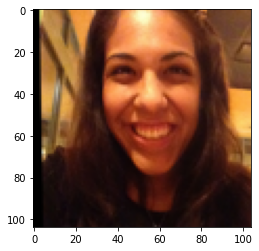

In [4]:
inf_dir = './data/test/'

# Base 3 layer CNN

model = get_model("Base_CNN_multi_task", "./models/")
output = inference(model, inf_dir)
print(output)

In [ ]:
# Base 3 layer CNN
model = get_model("Resnet_multi_task", "./models/best_model/")
output = inference(model, inf_dir)
print(output)